In [1]:
#First, make sure the notebook is aware of the workshop data sets
!git clone https://github.com/icomse/9th_workshop_ml_for_molecules.git
import os
os.chdir('9th_workshop_ml_for_molecules/data')

fatal: destination path '9th_workshop_ml_for_molecules' already exists and is not an empty directory.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### Building a deep learning model in Pytorch requires building multiple objects and routines:

1. <u>Dataset</u>- object that contains your training/validation data

2. <u>Model</u>- object that contains your model architecture and weights

3. <u>Train Routine</u>- function that passes training data through model and updates weights

4. <u>Validation Routine</u>- function that passes validation through model and reports performance

### To build Pytorch models, it is helpful to understand what an object is:
In Python, an object is a fundamental concept representing a specific instance of a class. It encapsulates data (attributes) and behavior (methods) into a single entity.

In [3]:
class Person: # Define an object corresponding to a person
    def __init__(self, name, age, gender): # Upon creating this object, we will run the following code to initialize attributes
        self.name = name
        self.age = age
        self.gender = gender
    def can_drive(self): # Create a function that tells us whether the person is old enough to drive
        return self.age>=16
    def __len__(self): # Create a function to tell us the number of letters in the person's name using the len function
        return len(self.name)

In [4]:
# Upon creating the object, it will automatically get attributes:
me = Person('Camille', 32, 'Female') # Create the object
print(me.name)
print(me.age)
print(me.gender)

Camille
32
Female


In [5]:
# We can also access functions that were defined for our class:
me.can_drive()

True

In [6]:
# The __len__(self): function allows us to use python's built-in len function:
print(me.name)
print(len(me))

Camille
7


With this background knowledge about what an object is we can build the objects needed for a Pytorch model.

## 1. Dataset
### What does our dataset look like?


In [7]:
data_path = 'lipo_fp_processed.csv'

In [8]:
df = pd.read_csv(data_path)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,lipo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.54
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-1.18
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.69
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,3.37
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.10


### The first 2048 columns contain bits of information about the input molecule. The last column contains information about how strongly that molecule binds to the protein.

### Let's define a PyTorch dataset object to read in this data:

In [9]:
# by calling Dataset (which we imported in the first cell) we build in all of the attributes of the pytorch Dataset object:
class LipoDataset(Dataset):
    def __init__(
        self,
        path,  # when we build the dataset, "path" will be a required input variable
    ):
        # read a csv from that path:
        self.df = pd.read_csv(path)

        # assign dataset attribute "input_vectors" to be the 2048 bit vector representing each molecule:
        self.input_vectors = self.df[self.df.columns[0:-1]].values

        # assign dataset attribute "output_targets" to be the scalar representing binding strength (last column):
        self.output_targets = self.df[self.df.columns[-1]].values

    # __len__(self) is a required method for the Dataset class; it must output the number of samples (in our case, 9880):
    def __len__(
        self,
    ):
        return len(self.output_targets)

    # __getitem__(self, idx) is a required method for the Dataset clas; it takes in an index "idx" to indicate the sample number:
    def __getitem__(self, idx):
        x = self.input_vectors[idx]
        y = self.output_targets[idx]

        return torch.tensor(x, dtype=torch.float32), torch.tensor(
            y, dtype=torch.float32
        )

### Let's test out our new dataset object:

In [10]:
dataset = LipoDataset(data_path)

In [11]:
print(dataset)

In [12]:
dataset.df.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,lipo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.54
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-1.18
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.69
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,3.37
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.10


In [13]:
len(dataset)

4200

## 2. Model

In [14]:
# Similarly, we can define our model as an object that is based on the existing PyTorch object "nn.Module":
class FCNN(nn.Module):

    # We can set up our model to take in an optional input "hidden_layer_size":
    def __init__(self, hidden_layer_size=256):
        super(FCNN, self).__init__()

        # Each layer in our network is an attribute of the model:
        self.layer1 = nn.Linear(1024, hidden_layer_size)
        self.layer2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.layer3 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.layer4 = nn.Linear(hidden_layer_size, 1)

    # PyTorch models require a "forward" method which tells PyTorch how to take an input and put it through the layers to reach the output:
    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        # x = F.relu(x)

        # We do not need an activation function after the last layer for a regression problem:

        return x

### Let's test out our new model object:

In [15]:
model = FCNN()

In [16]:
print(model)

FCNN(
  (layer1): Linear(in_features=1024, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=1, bias=True)
)


In [17]:
# We can easily change the size of the hidden_layer:
model = FCNN(512)
print(model)

FCNN(
  (layer1): Linear(in_features=1024, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=512, bias=True)
  (layer4): Linear(in_features=512, out_features=1, bias=True)
)


## 3. Train Routine:

In [18]:
def train(model, device, train_dataloader, optim):
    """
    model: torch.nn.Module; PyTorch model (FCNN)
    device: torch.device; device to be used for training (usually cpu)
    train_dataloader: torch.utils.data.DataLoader; dataloader object for training set
    optim: torch.optim; PyTorch optimizer
    """

    # Set the model to training mode:
    model.train()

    # Define loss function:
    l1_loss_fn = torch.nn.L1Loss(reduction="sum")

    # Create a loss variable to keep track of total losses in the test set
    loss_collect = 0

    # Looping over the dataloader allows us to pull out or input/output data:
    # Enumerate allows us to also get the batch number:
    for b_i, (X, y) in enumerate(train_dataloader):

        # Assign X and y to the appropriate device:
        X, y = X.to(device), y.to(device)

        # Zero out the optimizer:
        optim.zero_grad()

        # Make a prediction:
        pred_prob = model(X)

        # Calculate the loss:
        loss = l1_loss_fn(pred_prob, y.view(-1, 1))

        # Backpropagation:
        loss.backward()
        optim.step()

        # Calculate the loss and add it to our total loss
        loss_collect += loss.item()  # loss summed across the batch

    # Return our normalized losses so we can analyze them later:
    loss_collect /= len(train_dataloader.dataset)
    return loss_collect

### *Note: Ultimately it is useful to test this using an IDE with a debugger (e.g. Spyder or PyCharm) instead of a notebook, so that you can look inside these functions

## 4. Validation Routine:

In [19]:
def validation(model, device, val_dataloader, epoch):

    # Set our model to evaluation mode:
    model.eval()

    # Create a loss variable to keep track of total losses in the test set
    loss_collect = 0

    # Define loss function:
    l1_loss_fn = torch.nn.L1Loss(reduction="sum")

    # Remove gradients:
    with torch.no_grad():

        # Looping over the dataloader allows us to pull out or input/output data:
        for X, y in val_dataloader:

            # Assign X and y to the appropriate device:
            X, y = X.to(device), y.to(device)

            # Make a prediction:
            pred_prob = model(X)

            # Calculate the loss and add it to our total loss
            loss_collect += l1_loss_fn(
                pred_prob, y.view(-1, 1)
            ).item()  # loss summed across the batch

    loss_collect /= len(val_dataloader.dataset)
    # Print out our test loss so we know how things are going
    print(
        "\nEpoch:{}   Validation dataset: Loss per Datapoint: {:.4f}".format(
            epoch, loss_collect
        )
    )

    # Return our normalized losses so we can analyze them later:
    return loss_collect

## Pulling it all together:

In [20]:
## SET UP DATALOADERS: ---

# Build starting dataset:
dataset = LipoDataset(data_path)

# Number of datapoints in the training set:
n_train = int(len(dataset) * 0.8)

# Number of datapoints in the validation set:
n_val = len(dataset) - n_train

# Define pytorch training and validation set objects:
train_set, val_set = torch.utils.data.random_split(
    dataset, [n_train, n_val], generator=torch.Generator().manual_seed(42)
)

# Build pytorch training and validation set dataloaders:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)

In [21]:
## RUN TRAINING LOOP: ---

# Train with a random seed to initialize weights:
torch.manual_seed(0)

# Assign training to a device (often cpu when we are just starting out)
device = torch.device("cpu")

# Set up model:
model = FCNN(hidden_layer_size=256)
model.to(device)

# Set up optimizer:
optimizer = optim.Adadelta(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []

start_time = time.time()
for epoch in range(1, 30):
    train_loss = train(model, device, train_dataloader, optimizer)
    train_losses.append(train_loss)

    val_loss = validation(model, device, val_dataloader, epoch)
    val_losses.append(val_loss)

end_time = time.time()
print("Time Elapsed = {}s".format(end_time - start_time))


Epoch:1   Validation dataset: Loss per Datapoint: 2.0940

Epoch:2   Validation dataset: Loss per Datapoint: 2.0594

Epoch:3   Validation dataset: Loss per Datapoint: 2.0020

Epoch:4   Validation dataset: Loss per Datapoint: 1.8911

Epoch:5   Validation dataset: Loss per Datapoint: 1.6266

Epoch:6   Validation dataset: Loss per Datapoint: 1.1089

Epoch:7   Validation dataset: Loss per Datapoint: 1.0122

Epoch:8   Validation dataset: Loss per Datapoint: 1.0086

Epoch:9   Validation dataset: Loss per Datapoint: 1.0055

Epoch:10   Validation dataset: Loss per Datapoint: 1.0025

Epoch:11   Validation dataset: Loss per Datapoint: 0.9992

Epoch:12   Validation dataset: Loss per Datapoint: 0.9960

Epoch:13   Validation dataset: Loss per Datapoint: 0.9931

Epoch:14   Validation dataset: Loss per Datapoint: 0.9901

Epoch:15   Validation dataset: Loss per Datapoint: 0.9870

Epoch:16   Validation dataset: Loss per Datapoint: 0.9843

Epoch:17   Validation dataset: Loss per Datapoint: 0.9812

Epoch

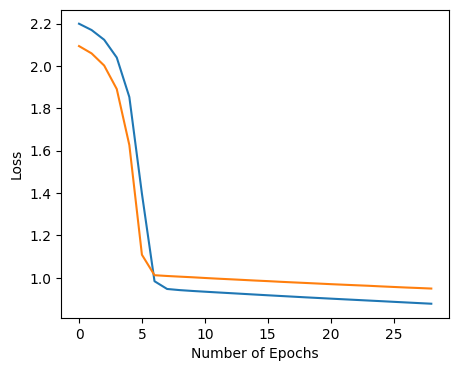

In [22]:
plt.figure(figsize=(5, 4), dpi=100)

plt.plot(train_losses)
plt.plot(val_losses)

plt.xlabel("Number of Epochs")
plt.ylabel("Loss")

plt.show()

In [23]:
def predict(model, device, dataloader):

    # Set our model to evaluation mode:
    model.eval()

    X_all = []
    y_all = []
    pred_prob_all = []

    # Remove gradients:
    with torch.no_grad():

        # Looping over the dataloader allows us to pull out or input/output data:
        for X, y in dataloader:

            # Assign X and y to the appropriate device:
            X, y = X.to(device), y.to(device)

            # Make a prediction:
            pred_prob = model(X)

            X_all.append(X)
            y_all.append(y)
            pred_prob_all.append(pred_prob)

    # Return our normalized losses so we can analyze them later:
    return (
        torch.concat(X_all),
        torch.concat(y_all),
        torch.concat(pred_prob_all).view(-1),
    )

In [24]:
X_all, y_all, pred_prob_all = predict(model, device, val_dataloader)

## We can calculate statistics to measure how well we did:

In [25]:
r2 = r2_score(y_all, pred_prob_all)
mae = mean_absolute_error(y_all, pred_prob_all)
mse = mean_squared_error(y_all, pred_prob_all)

print("R2 Score: {}".format(r2))
print("MAE: {}".format(mae))
print("MSE: {}".format(mse))

R2 Score: 0.07367168232604282
MAE: 0.9492286872606547
MSE: 1.4399873572026107


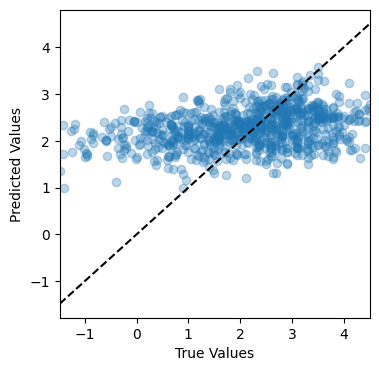

In [26]:
plt.figure(figsize=(4, 4), dpi=100)

plt.scatter(y_all, pred_prob_all, alpha=0.3)
plt.plot([min(y_all), max(y_all)], [min(y_all), max(y_all)], color="k", ls="--")
plt.xlim([min(y_all), max(y_all)])

plt.xlabel("True Values")
plt.ylabel("Predicted Values")

plt.show()

***HACKING:*** To make our model better we can try adjusting our hyperparameters. You can try:


*   Changing the learning rate
*   Changing the number of layers
*Changing the size of the layers

How do these choices impact your model performace?
How might you modify your code to take these hyperparameters as inputs to allow you to do a hyperparameter scan?

